In [34]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from collections import Counter
import warnings
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import json
import plotly
import plotly.express as px
import pickle
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# Read the processed data created from the Preprocess step
processed_data = pd.read_csv('./Dataset/Processed Data.csv')
processed_data.head()

Luddy or not? luddy_department        sense of belonging _1       sense of belonging _2       sense of belonging _3       sense of belonging _4       sense of belonging _5       sense of belonging _6       sense of belonging _7       sense of belonging _8       sense of belonging _9      sense of belonging _10      sense of belonging _11      sense of belonging _12      sense of belonging _13      sense of belonging _14      sense of belonging _15      sense of belonging _16                    Q19  Q12  Q13  Q15  Q16  Q17  Q14                        Q10                       Q11 Q12.1
0           Yes       Informatics              Strongly agree              Strongly agree              Strongly agree              Strongly agree              Strongly agree              Strongly agree              Strongly agree              Strongly agree              Strongly agree              Strongly agree              Strongly agree              Strongly agree              Strongly agree              Strongly agree              Strongly agree              Strongly agree  this is my first year  Yes  Yes  Yes  Yes  Yes  Yes  Non-binary / third gender         Prefer not to say    No
1           Yes  Computer Science  Neither agree nor disagree  Neither agree nor disagree  Neither agree nor disagree  Neither agree nor disagree  Neither agree nor disagree  Neither agree nor disagree  Neither agree nor disagree  Neither agree nor disagree  Neither agree nor disagree  Neither agree nor disagree  Neither agree nor disagree  Neither agree nor disagree  Neither agree nor disagree  Neither agree nor disagree  Neither agree nor disagree  Neither agree nor disagree  this is my first year  Yes   No  Yes   No  Yes   No          Prefer not to say        White or Caucasian   Yes
2           Yes       Informatics              Strongly agree              Strongly agree              Somewhat agree              Strongly agree              Strongly agree              Strongly agree              Somewhat agree              Strongly agree           Somewhat disagree  Neither agree nor disagree              Strongly agree              Strongly agree              Strongly agree              Strongly agree  Neither agree nor disagree              Strongly agree            three years  Yes   No  Yes  Yes  Yes  Yes                     Female        White or Caucasian    No
3           Yes       Informatics              Somewhat agree              Somewhat agree              Somewhat agree              Somewhat agree              Somewhat agree              Somewhat agree              Somewhat agree              Somewhat agree              Somewhat agree              Somewhat agree              Somewhat agree              Somewhat agree              Somewhat agree              Somewhat agree              Somewhat agree              Somewhat agree  this is my first year  Yes  Yes  Yes  Yes  Yes  Yes                       Male  White or Caucasian,Asian    No
4           Yes       Informatics              Somewhat agree              Strongly agree              Somewhat agree              Strongly agree              Strongly agree              Strongly agree              Strongly agree              Strongly agree              Strongly agree              Strongly agree              Strongly agree              Somewhat agree              Somewhat agree              Strongly agree              Strongly agree              Strongly agree              two years  Yes   No  Yes  Yes  Yes  Yes                       Male        White or Caucasian    No

In [4]:
processed_data.columns

Index(['Luddy or not?', 'luddy_department ', 'sense of belonging _1', 'sense of belonging _2', 'sense of belonging _3', 'sense of belonging _4', 'sense of belonging _5', 'sense of belonging _6', 'sense of belonging _7', 'sense of belonging _8', 'sense of belonging _9', 'sense of belonging _10', 'sense of belonging _11', 'sense of belonging _12', 'sense of belonging _13', 'sense of belonging _14', 'sense of belonging _15', 'sense of belonging _16', 'Q19', 'Q12', 'Q13', 'Q15', 'Q16', 'Q17', 'Q14', 'Q10', 'Q11', 'Q12.1'], dtype='object')

In [5]:
#Function to map ordinal categorical values to numbers
def create_mapping(df, sob_cols = [], binary_cols = []):
    assert len(sob_cols) > 0 or len(binary_cols) > 0
    if len(sob_cols) > 0:
        response_mapping = {'Strongly Disagree': 1, 'Somewhat disagree': 2, 'Neither agree nor disagree': 3, 
                'Somewhat agree': 4, 'Strongly agree': 5}
        for sob_col in sob_cols:
            df[sob_col] = df[sob_col].map(lambda x: response_mapping[x])
            
    if len(binary_cols) > 0:
        binary_mapping = {'Yes': 1, 'No': 0}
        for binary_col in binary_cols:
            df[binary_col] = df[binary_col].map(lambda x: binary_mapping[x])
    
    return df

#Function to One Hot Encode nominal categorical features
def one_hot_encoder(df, col):
    one_hot_df = pd.get_dummies(df[col])
    one_hot_df.columns = [col + '_' + column for column in one_hot_df.columns]
    df = pd.concat([df, one_hot_df], axis = 1)
    return df

In [6]:
# Create mapping of survey response values
sob_cols = ['sense of belonging _' + str(i) for i in range(1, 17)]
processed_data = create_mapping(processed_data, sob_cols = sob_cols)

binary_cols = ['Luddy or not?', 'Q12', 'Q12.1', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17']
processed_data = create_mapping(processed_data, binary_cols = binary_cols)

In [7]:
processed_data['Q11'].value_counts()

White or Caucasian                              117
Asian                                            75
Prefer not to say                                12
White or Caucasian,Asian                          5
Other                                             5
Black or African American                         5
White or Caucasian,Other                          1
White or Caucasian,Black or African American      1
Name: Q11, dtype: int64

In [8]:
# Drop ambiguous values
idx_to_drop = processed_data.loc[(processed_data['Q11'] == 'White or Caucasian,Black or African American') | 
                              (processed_data['Q11'] == 'White or Caucasian,Asian') |
                              (processed_data['Q11'] == 'White or Caucasian,Other')].index
processed_data = processed_data.drop(idx_to_drop)

In [9]:
# One hot encode nominal ordinal variables
columns_to_one_hot_encode = ['luddy_department ', 'Q19', 'Q10', 'Q11']
for column in columns_to_one_hot_encode:
    processed_data = one_hot_encoder(processed_data, column)

In [10]:
# Dropping redundant columns
processed_data = processed_data.drop(columns_to_one_hot_encode, axis = 1)

In [11]:
processed_data = processed_data.reset_index().drop('index', axis = 1)

#Convert the target variable to binary. All the values above 3 suggest that a student is proud to be part of Luddy School. Values below 3 suggest otherwise
for i in range(len(processed_data)):
    if processed_data['sense of belonging _14'][i] > 3:
        processed_data['sense of belonging _14'][i] = 1
    else:
        processed_data['sense of belonging _14'][i] = 0
processed_data.head()

Luddy or not?  sense of belonging _1  sense of belonging _2  sense of belonging _3  sense of belonging _4  sense of belonging _5  sense of belonging _6  sense of belonging _7  sense of belonging _8  sense of belonging _9  sense of belonging _10  sense of belonging _11  sense of belonging _12  sense of belonging _13  sense of belonging _14  sense of belonging _15  sense of belonging _16  Q12  Q13  Q15  Q16  Q17  Q14  Q12.1  luddy_department _Computer Science  luddy_department _Data Science  luddy_department _Informatics  luddy_department _Not from luddy  luddy_department _Other  Q19_four years  Q19_more than four years  Q19_this is my first year  Q19_three years  Q19_two years  Q10_Female  Q10_Male  Q10_Non-binary / third gender  Q10_Prefer not to say  Q11_Asian  Q11_Black or African American  Q11_Other  Q11_Prefer not to say  Q11_White or Caucasian
0              1                      5                      5                      5                      5                      5                      5                      5                      5                      5                       5                       5                       5                       5                       1                       5                       5    1    1    1    1    1    1      0                                   0                               0                              1                                 0                        0               0                         0                          1                0              0           0         0                              1                      0          0                              0          0                      1                       0
1              1                      3                      3                      3                      3                      3                      3                      3                      3                      3                       3                       3                       3                       3                       0                       3                       3    1    0    1    0    1    0      1                                   1                               0                              0                                 0                        0               0                         0                          1                0              0           0         0                              0                      1          0                              0          0                      0                       1
2              1                      5                      5                      4                      5                      5                      5                      4                      5                      2                       3                       5                       5                       5                       1                       3                       5    1    0    1    1    1    1      0                                   0                               0                              1                                 0                        0               0                         0                          0                1              0           1         0                              0                      0          0                              0          0                      0                       1
3              1                      4                      5                      4                      5                      5                      5                      5                      5                      5                       5                       5                       4                       4                       1                       5                       5    1    0    1    1    1    1      0                                   0                               0                              1                    

In [12]:
processed_data.shape

(214, 43)

In [13]:
X = processed_data.drop('sense of belonging _14', axis = 1) #Features
y = processed_data['sense of belonging _14'] #Target Variable

In [14]:
counter = Counter(y)

In [15]:
#Checking for Class Imbalance in the dataset
for key, value in counter.items():
    print(f'Class {key} has {value} responses which is {np.round((value/y.shape[0])*100, 4)}% of total reponses')

Class 1 has 161 responses which is 75.2336% of total reponses
Class 0 has 53 responses which is 24.7664% of total reponses


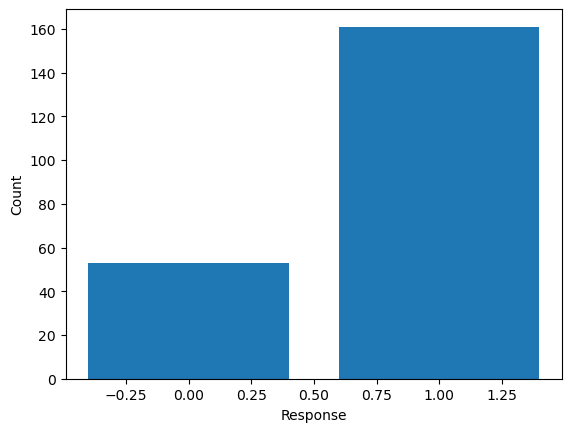

In [16]:
#A bar plot to display the imbalance in classes
plt.bar(counter.keys(), counter.values())
plt.xlabel('Response')
plt.ylabel('Count')
plt.show()

In [17]:
# Since the target variable is imbalanced, SMOTE is used to add artificial values to minority class
smote_object = SMOTE(k_neighbors = 2)
X_resampled, y_resampled = smote_object.fit_resample(X, y)
counter = Counter(y_resampled)
for key, value in counter.items():
    print(f'Class {key} has {value} responses which is {np.round((value/y.shape[0])*100, 4)}% of total reponses')

Class 1 has 161 responses which is 75.2336% of total reponses
Class 0 has 161 responses which is 75.2336% of total reponses


In [18]:
#Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.1, random_state = 42)

In [19]:
X_train.shape

(289, 42)

In [20]:
X_test.shape

(33, 42)

In [21]:
#Split the train set into train and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.15, random_state = 42)
X_train.shape

(245, 42)

In [22]:
X_val.shape

(44, 42)

In [23]:
# Trying out different models to identify the baseline model
linear_classifier = LogisticRegression(solver = 'liblinear')
linear_classifier.fit(X_train, y_train)
pred_train = linear_classifier.predict(X_train)
pred_val = linear_classifier.predict(X_val)
print('Accuracy on train set: {}'.format(accuracy_score(y_train, pred_train)))
print('Accuracy on validation set: {}'.format(accuracy_score(y_val, pred_val)))

Accuracy on train set: 0.9306122448979591
Accuracy on validation set: 0.7954545454545454


In [24]:
tree_classifier = DecisionTreeClassifier()
tree_classifier.fit(X_train, y_train)
pred_train = tree_classifier.predict(X_train)
pred_val = tree_classifier.predict(X_val)
print('Accuracy on train set: {}'.format(accuracy_score(y_train, pred_train)))
print('Accuracy on validation set: {}'.format(accuracy_score(y_val, pred_val)))

Accuracy on train set: 1.0
Accuracy on validation set: 0.8636363636363636


In [25]:
ensemble_classifier = RandomForestClassifier()
ensemble_classifier.fit(X_train, y_train)
pred_train = ensemble_classifier.predict(X_train)
pred_val = ensemble_classifier.predict(X_val)
print('Accuracy on train set: {}'.format(accuracy_score(y_train, pred_train)))
print('Accuracy on validation set: {}'.format(accuracy_score(y_val, pred_val)))

Accuracy on train set: 1.0
Accuracy on validation set: 0.8409090909090909


In [26]:
#Generating parameter grid for Logistic Regression as it is the baseline model. Decision Tree and Random Forest overfit the dataset
list_of_c_values = list(np.round(np.linspace(0, 2, 10000), 4)) 

In [27]:
# Cross Validation to find the most optimal value for C and the penalty type
param_grid = {'C': list_of_c_values, 'penalty': ['l1', 'l2']}

grid = GridSearchCV(LogisticRegression(solver = 'liblinear'), param_grid = param_grid, cv = 5, verbose = 3)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 20000 candidates, totalling 100000 fits
[CV 1/5] END ...................C=0.0, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END ...................C=0.0, penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END ...................C=0.0, penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END ...................C=0.0, penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END ...................C=0.0, penalty=l1;, score=nan total time=   0.0s
[CV 1/5] END ...................C=0.0, penalty=l2;, score=nan total time=   0.0s
[CV 2/5] END ...................C=0.0, penalty=l2;, score=nan total time=   0.0s
[CV 3/5] END ...................C=0.0, penalty=l2;, score=nan total time=   0.0s
[CV 4/5] END ...................C=0.0, penalty=l2;, score=nan total time=   0.0s
[CV 5/5] END ...................C=0.0, penalty=l2;, score=nan total time=   0.0s
[CV 1/5] END ..............C=0.0002, penalty=l1;, score=0.531 total time=   0.0s
[CV 2/5] END ..............C=0.0002, pena

GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': [0.0, 0.0002, 0.0004, 0.0006, 0.0008, 0.001,
                               0.0012, 0.0014, 0.0016, 0.0018, 0.002, 0.0022,
                               0.0024, 0.0026, 0.0028, 0.003, 0.0032, 0.0034,
                               0.0036, 0.0038, 0.004, 0.0042, 0.0044, 0.0046,
                               0.0048, 0.005, 0.0052, 0.0054, 0.0056, 0.0058, ...],
                         'penalty': ['l1', 'l2']},
             verbose=3)

In [28]:
grid.best_params_

{'C': 1.8774, 'penalty': 'l1'}

In [29]:
grid.best_score_

0.9183673469387754

In [30]:
#Fitting the best model on the data set
model = LogisticRegression(C = grid.best_params_['C'], penalty = grid.best_params_['penalty'], solver = 'liblinear')
model.fit(X_train, y_train)
pred_val = model.predict(X_val)
print('Accuracy on validation set: {}'.format(accuracy_score(y_val, pred_val)))
pred_test = model.predict(X_test)
print('Accuracy on test set: {}'.format(accuracy_score(y_test, pred_test)))

Accuracy on validation set: 0.8863636363636364
Accuracy on test set: 0.8484848484848485


In [31]:
coefs = model.coef_.ravel()
coefs.shape

(42,)

In [32]:
X_train.columns.shape

(42,)

In [33]:
#Looking at the importance of different features in prediction
feat_imp_df = pd.DataFrame({'Features': X_train.columns, 'Coefficients': coefs})
feat_imp_df = feat_imp_df.sort_values('Coefficients', ascending = False)
feat_imp_df = feat_imp_df[feat_imp_df['Coefficients'] != 0]

In [35]:
#Load the dictionary mapping Questions to feature names
with open('./Dataset/Questions_dict.json') as json_file:
    dict_of_columns = json.load(json_file)

#Shorten the length of keys so that it is easy to plot
substr = "Please rate your agreement with the following statements based on how you feel about the Luddy School. - "
old_keys = list(dict_of_columns.keys())
x = list(dict_of_columns.keys())
for i in range(len(x)):
    if x[i].find(substr) != -1:
        x[i] = x[i].replace(substr, "")
    else:
        continue

key_map = {old_keys[i]: x[i] for i in range(len(x))}


dict_of_columns = dict((key_map[key], value) for (key, value) in dict_of_columns.items())


In [36]:
#Map feature names to survey questions
feat_imp_df = feat_imp_df.reset_index().drop('index', axis = 1)
for key, value in dict_of_columns.items():
    for i in range(len(feat_imp_df)):
        if feat_imp_df['Features'][i] == value:
            feat_imp_df['Features'][i] = key


In [37]:
#Store the feature importance df to use it for plotting later
feat_imp_df.to_json('./Dataset/importance.json')

In [38]:
#Save the best model to use it for predictions in the app
MODEL_PATH = './model/logistic_regression.pkl'
with open(MODEL_PATH, 'wb') as file:
    pickle.dump(model, file)